<a href="https://colab.research.google.com/github/Edna-cyber/telepresence/blob/3d/3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
from PIL import Image
import numpy as np
import sys
import torch
import matplotlib.pyplot as plt

In [3]:
# code for installing pytorch3d inside Google Colab
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install fvcore iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 764.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=9c8382099f4ecf9d55ebc9f28309797197e6c8f66fd919c12855dc9a88e36cf2
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=8cdb23331bdf8c511d326905129145910a1021e239fbd8b96b54184d4498b9e3
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt221/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.4/20.4 MB 168.6 MB/s eta 0:00:00


In [4]:
import pytorch3d
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
)
from pytorch3d.structures import Pointclouds

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
image = Image.open("/content/drive/MyDrive/Gaussian/panda.png")
image_np = np.array(image)
image_normalized = image_np.astype(np.float32) / 255.0

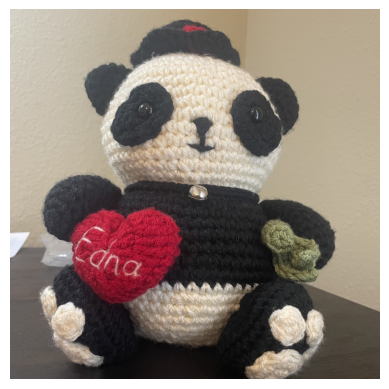

In [7]:
plt.imshow(image_normalized)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [19]:
f = 3000 # focal length in pixels, calculated from iphone data # modified
image_resolution = (3024, 3024)

In [20]:
def uv_to_xyz(u, v, d):
    """
    Convert 2D image coordinates (u, v) to 3D world coordinates (x, y, z).

    Parameters:
    - u, v: The 2D image coordinates.
    - f: The focal length of the camera in pixels.
    - d: The depth from the camera to the physical object.
    - principal_point: A tuple (u_0, v_0) representing the principal point of the camera (usually the image center).

    Returns:
    - A tuple (x, y, z) representing the 3D world coordinates.
    """
    w, h = image_resolution
    u_0, v_0 = w/2, h/2
    z = d
    x = (u-u_0)*z/f
    y = (v-v_0)*z/f
    return (x,y,z)

In [21]:
# Example usage
u, v = 700, 400 # example 2D image coordinates
d = 1
x, y, z = uv_to_xyz(u, v, d)
print(f"3D coordinates: x={x}, y={y}, z={z}")

3D coordinates: x=-0.27066666666666667, y=-0.37066666666666664, z=1


In [30]:
def twod_to_threed_lifting(f,d):
    w, h = image_resolution
    u_grid, v_grid = np.meshgrid(np.arange(w), np.arange(h))
    vectorized_func = np.vectorize(uv_to_xyz)
    x, y, z = vectorized_func(u_grid, v_grid, d)
    threed_coordinates = np.stack((x, y, z), axis=-1)
    print(threed_coordinates.shape)
    print(threed_coordinates)
    return np.stack((x, y, z), axis=-1)

In [31]:
far_threed_coord = twod_to_threed_lifting(f,1)

(3024, 3024, 3)
[[[-0.504      -0.504       1.        ]
  [-0.50366667 -0.504       1.        ]
  [-0.50333333 -0.504       1.        ]
  ...
  [ 0.503      -0.504       1.        ]
  [ 0.50333333 -0.504       1.        ]
  [ 0.50366667 -0.504       1.        ]]

 [[-0.504      -0.50366667  1.        ]
  [-0.50366667 -0.50366667  1.        ]
  [-0.50333333 -0.50366667  1.        ]
  ...
  [ 0.503      -0.50366667  1.        ]
  [ 0.50333333 -0.50366667  1.        ]
  [ 0.50366667 -0.50366667  1.        ]]

 [[-0.504      -0.50333333  1.        ]
  [-0.50366667 -0.50333333  1.        ]
  [-0.50333333 -0.50333333  1.        ]
  ...
  [ 0.503      -0.50333333  1.        ]
  [ 0.50333333 -0.50333333  1.        ]
  [ 0.50366667 -0.50333333  1.        ]]

 ...

 [[-0.504       0.503       1.        ]
  [-0.50366667  0.503       1.        ]
  [-0.50333333  0.503       1.        ]
  ...
  [ 0.503       0.503       1.        ]
  [ 0.50333333  0.503       1.        ]
  [ 0.50366667  0.503       

In [32]:
close_threed_coord = twod_to_threed_lifting(f,0.5)

(3024, 3024, 3)
[[[-0.252      -0.252       0.5       ]
  [-0.25183333 -0.252       0.5       ]
  [-0.25166667 -0.252       0.5       ]
  ...
  [ 0.2515     -0.252       0.5       ]
  [ 0.25166667 -0.252       0.5       ]
  [ 0.25183333 -0.252       0.5       ]]

 [[-0.252      -0.25183333  0.5       ]
  [-0.25183333 -0.25183333  0.5       ]
  [-0.25166667 -0.25183333  0.5       ]
  ...
  [ 0.2515     -0.25183333  0.5       ]
  [ 0.25166667 -0.25183333  0.5       ]
  [ 0.25183333 -0.25183333  0.5       ]]

 [[-0.252      -0.25166667  0.5       ]
  [-0.25183333 -0.25166667  0.5       ]
  [-0.25166667 -0.25166667  0.5       ]
  ...
  [ 0.2515     -0.25166667  0.5       ]
  [ 0.25166667 -0.25166667  0.5       ]
  [ 0.25183333 -0.25166667  0.5       ]]

 ...

 [[-0.252       0.2515      0.5       ]
  [-0.25183333  0.2515      0.5       ]
  [-0.25166667  0.2515      0.5       ]
  ...
  [ 0.2515      0.2515      0.5       ]
  [ 0.25166667  0.2515      0.5       ]
  [ 0.25183333  0.2515      

In [25]:
# x,y,z,r,g,b
far_lifted_coord = np.concatenate((far_threed_coord, image_normalized), axis=2)
far_lifted_coord.shape

(3024, 3024, 6)

In [26]:
close_lifted_coord = np.concatenate((close_threed_coord, image_normalized), axis=2)

In [33]:
def render(points, colors):
    points = torch.tensor(points, dtype=torch.float32)
    points = points.view(-1, points.size(-1)).to(device)

    # Create a point cloud structure
    colors = torch.tensor(colors, dtype=torch.float32)
    colors = colors.view(-1, colors.size(-1)).to(device)

    # Create the Pointclouds object with points and their associated colors
    cloud = Pointclouds(points=[points], features=[colors])

    R, T = look_at_view_transform(2.7, 0, 180)  # camera distance, elevation, azimuth
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    # Rasterization settings for rendering the point cloud, can adjust the size of the points, etc.
    raster_settings = PointsRasterizationSettings(
        image_size=512,
        radius = 0.003,
        points_per_pixel = 10
    )

    # Point renderer for rendering the point cloud
    renderer = PointsRenderer(
        rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
        compositor=AlphaCompositor()
    )

    images = renderer(cloud)
    image_np = images[0, ..., :3].cpu().numpy()  # discard the alpha channel
    plt.imshow(image_np)
    plt.show()

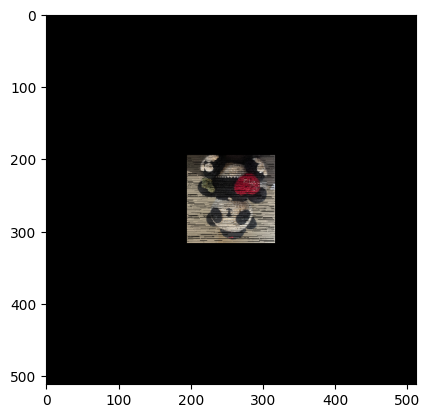

In [34]:
far_gt = render(far_threed_coord, image_normalized)

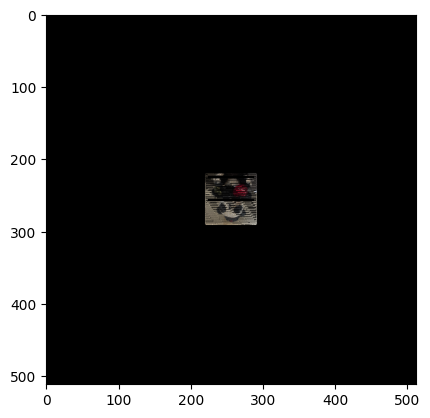

In [35]:
close_gt = render(close_threed_coord, image_normalized)